### Setup

In [76]:
import skrf as rf
from skrf.constants import K_BOLTZMANN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.interpolate import interp1d
from devices.devices_lib import make_cavity__with_antennas_network # From Chirstan Boutan's PNNL team
import components as cmp # From Jihee
import os.path

%matplotlib inline

In [77]:
## Paths to files - change to location of amplifier data

ZX60_33LN_NF_loc_PATH = r'./data/amplifier_data/ZX60-33LN-S+NF_DATA.csv'
AMP_PATH = './data/touchstone_files/amplifiers'
AMP_NAME = 'ZX60-33LNR-S+_UNIT1_.s2p' #Our amplifier is ZX60-33LN-S+, gain of LNR ~0.1 dB less at 1 Ghz

In [78]:
min_freq = 0.5e9
max_freq = 2.9e9 #Needs to be less than 3ghz for amplifier data

freq = rf.frequency.Frequency(start=min_freq/1e9, stop=max_freq/1e9, npoints=1001, unit='ghz', sweep_type='lin')
Troom = 290

In [79]:
###############################
##### Component Functions   ###
###############################
#(From Jihee's components.py and analyis_run1C_tsys.py)

pow_to_dbm = lambda x: 10*np.log(x/1e-3)
db_to_power_ratio = lambda x: 10**(x/10)

dBm_to_W = lambda p_dBm: 10**(p_dBm/10)/1000
power_in_dBm_per_Hz_to_temp = lambda p: dBm_to_W(p)/K_BOLTZMANN

### Function to read network in noisy environment ###
def read_in_noisy_network(ntw,freq_interp,Tphys):
    ntw_interp = ntw.interpolate(freq_interp, kind='cubic')
    ntw_interp_noisy = rf.NoisyNetwork(ntw_interp)
    ntw_interp_noisy.noise_source(source='passive',T0 = Tphys)

    return ntw_interp_noisy

### Function to make coaxial cable with coaxial line and SMA connector sample ###
def make_coax_cable(c_type,freq,len_m,Tphys):
        
    if c_type=='RG405U':
        ntw_coax_RT = cmp.cable_RG405U(freq,len_m)
        ntw_coax_cryo = cmp.RT2Cryo(ntw_coax_RT)
        # ntw_coax_cryo = ntw_coax_RT
        # ntw_SMA_RT = cmp.cable_RG405U(freq,0.04)
        ntw_SMA_RT = cmp.SMA_RG405U(freq,0.015)
        ntw_SMA_cryo = cmp.RT2Cryo(ntw_SMA_RT)
        # ntw_SMA_cryo = ntw_SMA_RT
    elif c_type=='PESR405FL':    
        ntw_coax_RT = cmp.cable_PESR405FL(freq,len_m)
        ntw_coax_cryo = cmp.RT2Cryo(ntw_coax_RT)
        # ntw_coax_cryo = ntw_coax_RT
        # ntw_SMA_RT = cmp.cable_PESR405FL(freq,0.04)
        ntw_SMA_RT = cmp.SMA_PESR405FL(freq,0.015)
        ntw_SMA_cryo = cmp.RT2Cryo(ntw_SMA_RT)
        # ntw_SMA_cryo = ntw_SMA_RT
    elif c_type=='NbTi085':
        ntw_coax_cryo = cmp.cable_NbTi085(freq,len_m)
        ntw_SMA_cryo = cmp.cable_NbTi085(freq,0.015)
    else:
        print('Error: Proper cable type is missing')

    noisy_ntw_coax = read_in_noisy_network(ntw_coax_cryo,freq,Tphys)
    noisy_ntw_SMA = read_in_noisy_network(ntw_SMA_cryo, freq, Tphys)
    
    assmb_cable = rf.MultiNoisyNetworkSystem()

    noisy_ntw_SMA.add_noise_polar(1e-6, 0.5)
    assmb_cable.add(noisy_ntw_SMA,'SMA1')
    assmb_cable.add(noisy_ntw_coax,'coax')
    noisy_ntw_SMA.add_noise_polar(1e-6, 0.55)
    assmb_cable.add(noisy_ntw_SMA,'SMA2')

    assmb_cable.connect('SMA1',2, 'coax',1)
    assmb_cable.connect('coax',2, 'SMA2',1)

    assmb_cable.external_port('SMA1',1,1)
    assmb_cable.external_port('SMA2',2,2)

    noisy_ntw_cable = assmb_cable.reduce()
    noisy_ntw_cable = read_in_noisy_network(noisy_ntw_cable,freq,Tphys)
        
    return noisy_ntw_cable  

In [80]:
# Creates a function of frequency that returns amplifier noise figure amplitudu
def gen_ZX60_33LN_S_NF_func(ZX60_33LN_NF_loc):
    
    # read in nf data from a csv
    # convert noise figure in db to amplitude
    # Make a new column with frequency in GHz
    # Interpolate noise figure as a function of frequency
    
    noise_figure_data2 = pd.read_csv(ZX60_33LN_NF_loc , header = 'infer')
    noise_figure_data2['NF Amplitude'] = 10**(noise_figure_data2['Noise Figure (5V)']/10)
    noise_figure_data2['Frequency (GHz)'] = noise_figure_data2['Frequency (MHz)']/1e3
    NF_Func2 = interp1d(noise_figure_data2['Frequency (GHz)'],noise_figure_data2['NF Amplitude'])#,fill_value=1000) # <- extrapolate ok here?
    
    return NF_Func2

def return_ZX60_33LN_params(Amp_path,Amp_name,freq,sat_check=False,vendor=True,Temp=290):
    
    # create amplifier from manufacturer's s2p file
    
    ZX60_33LN_NF_loc = ZX60_33LN_NF_loc_PATH
    
    Tphys = Temp
    
    Amp_loc = os.path.join(Amp_path,Amp_name)
    amp_sparam = rf.Network(Amp_loc)
    amp_sparam = amp_sparam.interpolate(freq,kind='cubic')
    amp_sparam  = rf.NoisyNetwork(amp_sparam)
    amp_sparam.noise_source(source='passive',T0=Tphys) # <-- why do we need this is we are specifying the cs matrix from the datasheet?
    
    # generate noise figure function
    
    #try:
    NF_func = gen_ZX60_33LN_S_NF_func(ZX60_33LN_NF_loc)
    nfig = NF_func(freq.f/1e9)
    #except:
       # print('error')
       # return
    
    # use noise figure function to specify noise covariance matrix
    # cs}_ii = k_B T_0 S A S^dagger }_ii (F_i - 1)
        
    Tnoise = rf.NetworkNoiseCov.Tnoise(freq.f,Tphys) # <-- where is this noise temperature used?
    
    I = np.identity(np.shape(amp_sparam.s)[1])
    AS = np.matmul(I,np.conjugate(amp_sparam.s.swapaxes(1,2)))
    SAS = np.matmul(amp_sparam.s,AS)
    
    amp_sparam.cs[:,0,0] = (nfig - 1) * K_BOLTZMANN * 290 * SAS[:,0,0]
    
    I = np.identity(np.shape(amp_sparam.s)[1])
    AS = np.matmul(I,np.conjugate(amp_sparam.s.swapaxes(1,2)))
    SAS = np.matmul(amp_sparam.s,AS)
    
    amp_sparam.cs[:,1,1] = (nfig-1) * K_BOLTZMANN * 290 * SAS[:,1,1]
    
    amp_sparam.cs[:,0,1] = np.zeros_like(amp_sparam.cs[:,1,1])
    amp_sparam.cs[:,1,0] = amp_sparam.cs[:,0,1]
    
    return amp_sparam
    

In [81]:
def create_measured_circulator(freq):
    
    s_circ_db = np.array([[-22,-0.8,-0.8],
                          [-30,-22,-0.8],
                          [-31,-25,-21]])
    
    
    s_circ = 10**(s_circ_db/10)

    s = np.zeros((len(freq),3,3), dtype ="complex_")
    
    #Assumes clockwise circulator (1=>2=>3=>1...)
    s[:,0,0] = s_circ[0,0]
    s[:,0,1] = s_circ[0,1]
    s[:,0,2] = s_circ[0,2]
    s[:,1,0] = s_circ[1,0]
    s[:,1,1] = s_circ[1,1]
    s[:,1,2] = s_circ[1,2]
    s[:,2,0] = s_circ[2,0]
    s[:,2,1] = s_circ[2,1]
    s[:,2,2] = s_circ[2,2]
    
    ntw_circ = rf.Network(frequency=freq, s=s)
    
    return ntw_circ

### Plotting s params for test circuit

- very high cavity resistance results in asymmetry (but not like we observed? why is this the case?)

In [82]:
def make_circuits():
    """
    Makes networks for different circulator and cavity configurations
    """
    
    
#     #Amplifier

#     amp_path = '/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data'
#     amp_name = 'ZX60-33LNR-S+_UNIT1_.s2p' #Our amplifier is ZX60-33LN-S+, gain of LNR ~0.1 dB less at 1 Ghz

#     amp_sparam = return_ZX60_33LN_params(amp_path,amp_name,freq)

#     noisy_ntw_amp_1 = amp_sparam
#     noisy_ntw_amp_2 = amp_sparam
    
    # Cables
    
    LEN_CABLE = 0.01 #m
    noisy_ntw_cable = make_coax_cable('RG405U',freq,LEN_CABLE,Troom)

    #Cavity

    freq_cavity = 2.027e9 # Measured
    R_cavity= 500_000 # [[Not measured, what is a reasonable value for cavity resistance?]]
    Q_cavity= 163.9 # Measured

    start_freq = min_freq
    stop_freq = max_freq

    ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity) # [[What are the N's here?]]
    noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, Troom)

    #Circulator
    ntw_circ_1 = create_measured_circulator(freq)
    noisy_ntw_circ_1 = read_in_noisy_network(ntw_circ_1, freq, Troom)


    #Terminator
    termi_gamma = db_to_power_ratio(-26.6) # measured
    ntw_termi_1 = cmp.create_terminator(freq,Gamma_0=termi_gamma)
    noisy_ntw_termi_1 = read_in_noisy_network(ntw_termi_1, freq, Troom) 
    
    def make_blue_circuit():
        # Circuit diagram

        # (SA) - 1 - [circ] - 2 - 1 [cavity] 2 - 1 [termi1]
        #              3
        #              |
        #           [termi2]
        #           

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_cav,'cav')
        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_1,'termi1')
        mnns.add(noisy_ntw_termi_1,'termi2')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'cav',2)
        mnns.connect('cav',1,'circ',2)
        mnns.connect('termi2',1,'circ',3)
       
        mnns.external_port('circ',1,1)

        assem_mnns = mnns.reduce()

        return assem_mnns

        
    # Create circuits
    blue_circuit = make_blue_circuit()
    
    # return dictionary for plotting
    
    #ntw_dict = {'pink': pink_circuit,'blue': blue_circuit,'yellow':yellow_circuit,'red':red_circuit,'teal':teal_circuit}
    ntw_dict = {'blue': blue_circuit}
    
    return ntw_dict
        
    

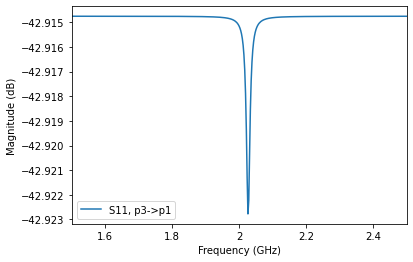

In [83]:
ntw_dict = make_circuits()

blue_circuit = ntw_dict['blue']
blue_circuit['1.5-2.5ghz'].plot_s_db(m=0,n=0,label='S11, p3->p1')
#blue_circuit['1.5-2.5ghz'].plot_s_db(m=1,n=0,label='S21')

In [84]:
np.shape(blue_circuit.cs)

(1001, 1, 1)

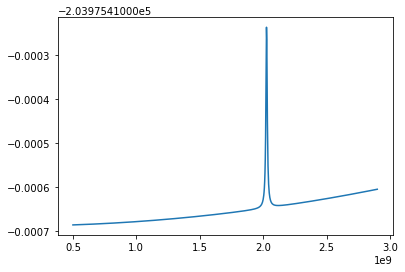

In [85]:
plt.plot(freq.f,10*np.log10(abs(blue_circuit.cs[:,0,0]))/.001)

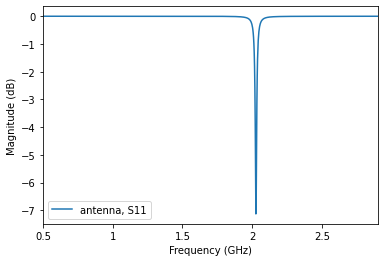

In [86]:
#Cavity

freq_cavity = 2.027e9 # Measured
R_cavity= 5_000 # [[Not measured, what is a reasonable value for cavity resistance?]]
Q_cavity= 163.9 # Measured

start_freq = min_freq
stop_freq = max_freq

ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity) # [[What are the N's here?]]
noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, Troom)

noisy_ntw_cav.plot_s_db(m=0,n=0)

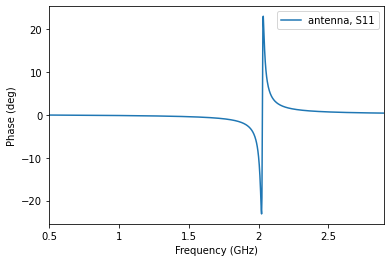

In [87]:
noisy_ntw_cav.plot_s_deg(m=0,n=0)

# Noise temp of back of amplifier

#### Measuring noise power (method 1)

- connect amplifier to perfect terminator, measure power coming out the back

Garcia-Garcia Eqn 12 for 1-port network:

$C_{11} = k_B T (1 - |S_{11}|^2)$

#### Making circuit

In [88]:
#Amplifier

amp_path = AMP_PATH 
amp_name = AMP_NAME 

amp_sparam = return_ZX60_33LN_params(amp_path,amp_name,freq)

noisy_ntw_amp_1 = amp_sparam
    
#Terminator

#termi_gamma = db_to_power_ratio(-26.6) # measured
termi_gamma = 0
ntw_termi_1 = cmp.create_terminator(freq,Gamma_0=termi_gamma)
noisy_ntw_termi_1 = read_in_noisy_network(ntw_termi_1, freq, Troom) 

In [89]:
    

def make_amp_test_circuit():
    
        # Circuit diagram:

        # [termi]-1 <-> 2-[amp]-1
      
        
        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_amp_1,'amp')
        mnns.add(noisy_ntw_amp_1,'amp2')
        mnns.add(noisy_ntw_termi_1,'termi')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi',1,'amp2',2)
        mnns.connect('amp',2,'amp2',1)
     
        mnns.external_port('amp',1,1)

        assem_mnns = mnns.reduce()

        return assem_mnns

#### Plotting noise power from back

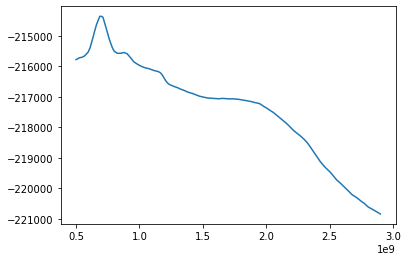

In [90]:
amp_test_circuit = make_amp_test_circuit()
plt.plot(freq.f,10*np.log10(abs(amp_test_circuit.cs[:,0,0]))/.001)

#### Noise temp on and off resonance 

Text(0, 0.5, 'Temperature [K]')

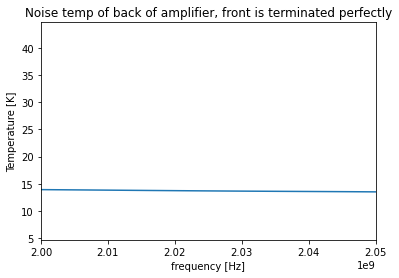

In [91]:
s11 = np.abs(amp_test_circuit.s[:,0,0])
amp_test_circuit_noise_temp = np.abs(amp_test_circuit.cs[:,0,0]/(K_BOLTZMANN * (1- s11**2)))
plt.plot(freq.f,amp_test_circuit_noise_temp)
plt.xlim(2.0e9,2.05e9)
plt.title('Noise temp of back of amplifier, front is terminated perfectly'); plt.xlabel('frequency [Hz]'); plt.ylabel('Temperature [K]')

# Effect of leakage on asymmetry

#### Cavity s params and phase shift

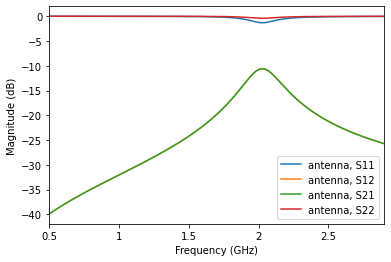

In [92]:
#Cavity

freq_cavity = 2.027e9 # Measured
R_cavity= 100 # [[Not measured, what is a reasonable value for cavity resistance?]]
Q_cavity= 163.9 # Measured

start_freq = min_freq
stop_freq = max_freq

ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity) # [[What are the N's here?]]
noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, Troom)

noisy_ntw_cav.plot_s_db()

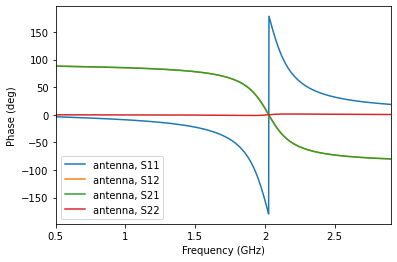

In [93]:
noisy_ntw_cav.plot_s_deg()

### Looking for asymmetry due to leakage and reflection of circulator

( The 'blue' circuit is the circuit with circulator connected to terminator, cavity, and amps as shown in picture below) 

- The leakage of the circulator should allow phase-shifted signals to pass through from the cavity (from both reflection and transmission from the terminator).

- The interference of the phase-shifted signal and the signal we observe could result in asymmetry, since the signal would destructively or constructively interfere at different frequencies

Blue circuit:
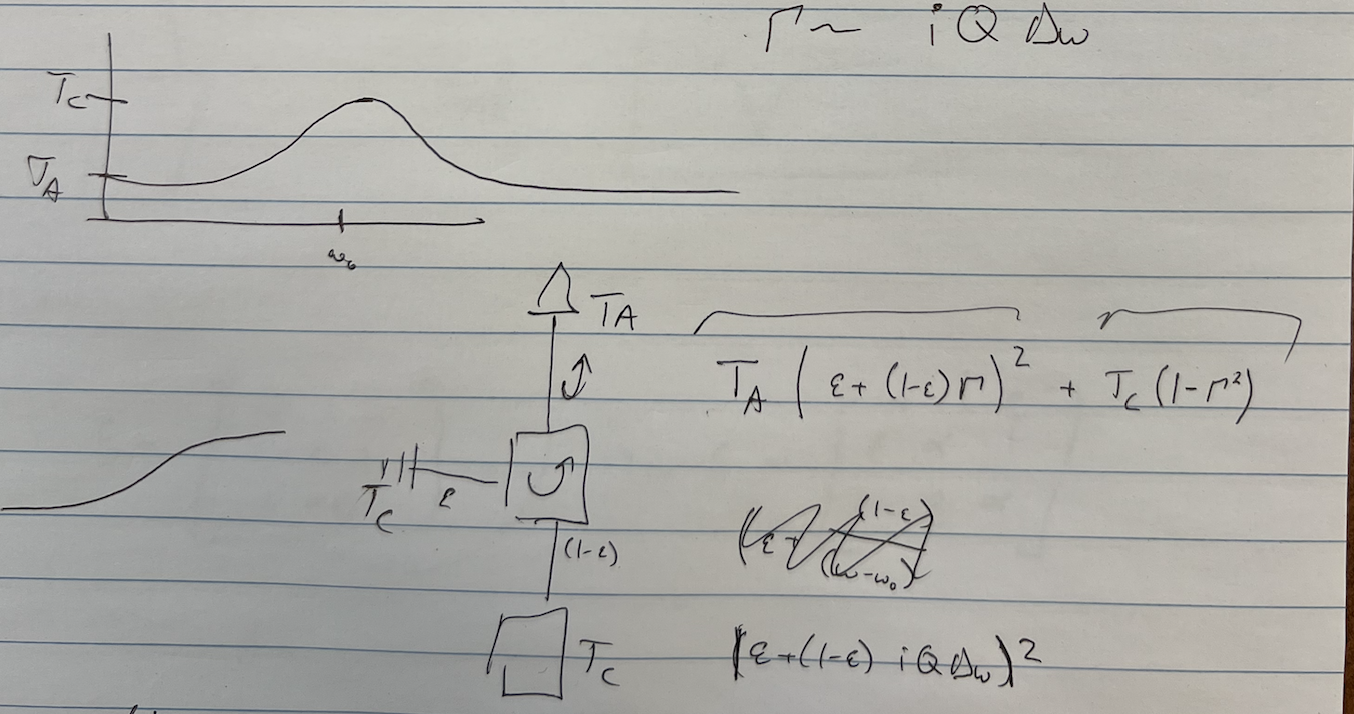

#### Circuit setup

In [94]:
def create_circulator_variable_leakage(freq,leakage,reflection):
    
    l = leakage
    g = reflection
    s_circ_db = np.array([[g,   l,-0.8],
                          [-0.8,g,   l],
                          [l, -0.8,  g]])
    
    
    s_circ = 10**(s_circ_db/10)

    s = np.zeros((len(freq),3,3), dtype ="complex_")
    
    #Assumes clockwise circulator (1=>2=>3=>1...)
    s[:,0,0] = s_circ[0,0]
    s[:,0,1] = s_circ[0,1]
    s[:,0,2] = s_circ[0,2]
    s[:,1,0] = s_circ[1,0]
    s[:,1,1] = s_circ[1,1]
    s[:,1,2] = s_circ[1,2]
    s[:,2,0] = s_circ[2,0]
    s[:,2,1] = s_circ[2,1]
    s[:,2,2] = s_circ[2,2]
    
    ntw_circ = rf.Network(frequency=freq, s=s)
    
    return ntw_circ

In [103]:
def make_circuits_variable_leakage(leakage,reflection,cav_r=100):
    """
    Makes networks for different circulator and cavity configurations and returns a dictionary of circuits..
    The leakage and reflection parameters are for the circulator, and the cav_r parameter is for the cavity resistance.
    
    
    - blue circuit is the name for the network with a circulator connected to a cavity, with one of the ports of the circulator terminated.
        There are four versions of the network for with/without amplifiers and with a room temp/cold terminator.
        
    - case 1 and 2 circuits are used for plotting reflection and transmission through a circulator to test the effect on the asymmetry of the noise temp spectrum  
    
    - cav circuit is a network with only a cavity, with/without amplifiers
    
    
    """
    
    
    #Amplifier

    amp_path = AMP_PATH
    amp_name = AMP_NAME #Our amplifier is ZX60-33LN-S+, gain of LNR ~0.1 dB less at 1 Ghz

    amp_sparam = return_ZX60_33LN_params(amp_path,amp_name,freq)

    noisy_ntw_amp_1 = amp_sparam
    noisy_ntw_amp_2 = amp_sparam
    
    # Cables
    
    LEN_CABLE = 0.01 #m
    noisy_ntw_cable = make_coax_cable('RG405U',freq,LEN_CABLE,Troom)

    #Cavity

    freq_cavity = 2.027e9 # Measured
    R_cavity= cav_r # [[Not measured, what is a reasonable value for cavity resistance?]]
    Q_cavity= 163.9 # Measured

    start_freq = min_freq
    stop_freq = max_freq

    ntw_cav = make_cavity__with_antennas_network(start_freq,freq_cavity, stop_freq, N1=7, N2 = .9, R = R_cavity, Q = Q_cavity) # [[What are the N's here?]]
    noisy_ntw_cav = read_in_noisy_network(ntw_cav, freq, Troom)

    #Circulator 
    ntw_circ_1 = create_circulator_variable_leakage(freq,leakage,reflection) # <- f-n params
    #ntw_circ_1 = cmp.create_ideal_circulator(freq)
    noisy_ntw_circ_1 = read_in_noisy_network(ntw_circ_1, freq, Troom)


    #Terminator
    termi_gamma = db_to_power_ratio(-26.6) # measured
    ntw_termi_1 = cmp.create_terminator(freq,Gamma_0=termi_gamma)
    noisy_ntw_termi_1 = read_in_noisy_network(ntw_termi_1, freq, Troom) 
    noisy_ntw_termi_cold = read_in_noisy_network(ntw_termi_1, freq, 77)
    
    def make_blue_circuit_amps():
        # Circuit diagram

        # (SA) - amps - 1 - [circ] - 2 - 1 [cavity] 2 - 1 [termi1]
        #                     3
        #                     |
        #                  [termi2]
        #           

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_cav,'cav')
        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_1,'termi1')
        mnns.add(noisy_ntw_termi_1,'termi2')
        mnns.add(noisy_ntw_amp_1,'amp1')
        mnns.add(noisy_ntw_amp_2,'amp2')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'cav',2)
        mnns.connect('cav',1,'circ',2)
        mnns.connect('termi2',1,'circ',3)
        mnns.connect('circ',1,'amp1',1)
        mnns.connect('amp1',2,'amp2',1)
       
        mnns.external_port('amp2',2,1)

        assem_mnns = mnns.reduce()

        return assem_mnns
    
    def make_blue_circuit_amps_cold_termi():
        # Circuit diagram

        # (SA) - amps - 1 - [circ] - 2 - 1 [cavity] 2 - 1 [termi1]
        #                     3
        #                     |
        #                  [termi cold]
        #           

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_cav,'cav')
        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_1,'termi1')
        mnns.add(noisy_ntw_termi_cold,'termi_cold')
        mnns.add(noisy_ntw_amp_1,'amp1')
        mnns.add(noisy_ntw_amp_2,'amp2')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'cav',2)
        mnns.connect('cav',1,'circ',2)
        mnns.connect('termi_cold',1,'circ',3)
        mnns.connect('circ',1,'amp1',1)
        mnns.connect('amp1',2,'amp2',1)
       
        mnns.external_port('amp2',2,1)

        assem_mnns = mnns.reduce()

        return assem_mnns
    
    def make_blue_circuit():
        # Circuit diagram

        # (SA) - 1 - [circ] - 2 - 1 [cavity] 2 - 1 [termi1]
        #              3
        #              |
        #           [termi2]
        #           

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_cav,'cav')
        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_1,'termi1')
        mnns.add(noisy_ntw_termi_1,'termi2')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'cav',2)
        mnns.connect('cav',1,'circ',2)
        mnns.connect('termi2',1,'circ',3)
       
        mnns.external_port('circ',1,1)

        assem_mnns = mnns.reduce()

        return assem_mnns
    
    def make_blue_circuit_cold_termi():
        # Circuit diagram

        # (SA) - 1 - [circ] - 2 - 1 [cavity] 2 - 1 [termi1]
        #              3
        #              |
        #           [termi cold]
        #           

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_cav,'cav')
        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_1,'termi1')
        mnns.add(noisy_ntw_termi_cold,'termi_cold')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'cav',2)
        mnns.connect('cav',1,'circ',2)
        mnns.connect('termi_cold',1,'circ',3)
       
        mnns.external_port('circ',1,1)

        assem_mnns = mnns.reduce()

        return assem_mnns
    

    
    def make_amp_cav_circuit():
        # Circuit diagram

        # (SA) - amp - [circ] - 2 - 1 [cavity] 2 - 1 [termi1]
           

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_cav,'cav')
        mnns.add(noisy_ntw_amp_1,'amp1')
        mnns.add(noisy_ntw_amp_2,'amp2')
        mnns.add(noisy_ntw_termi_1,'termi1')
       


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'cav',2)
        mnns.connect('cav',1,'amp1',1)
        mnns.connect('amp1',2,'amp2',1)
       
        mnns.external_port('amp2',2,1)

        assem_mnns = mnns.reduce()

        return assem_mnns
    
    def make_cav_circuit():
        # Circuit diagram

        # (SA) - [circ] - 2 - 1 [cavity] 2 - 1 [termi1]
           

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_cav,'cav')
        mnns.add(noisy_ntw_termi_1,'termi1')
       


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'cav',2)
       
        mnns.external_port('cav',1,1)

        assem_mnns = mnns.reduce()

        return assem_mnns
        
    
    def make_case2_circuit():
        # Circuit diagram

        # {port 2} - 1 - [circ] - 2 - 1 [cavity] 2 - 1 [termi1]
            #              3
            #              |
            #             {port 1}
        #           

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_cav,'cav')
        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_1,'termi1')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'cav',2)
        mnns.connect('cav',1,'circ',2)
        
       
        mnns.external_port('circ',3,1)
        mnns.external_port('circ',1,2)

        assem_mnns = mnns.reduce()

        return assem_mnns
    
    def make_circ_circuit():
        # Circuit diagram

        # {port 1} - 1 - [circ] - 2 - 1 [termi]
            #              3
            #              |
            #            [termi]
        #           

        mnns = rf.MultiNoisyNetworkSystem()

        mnns.add(noisy_ntw_circ_1,'circ')
        mnns.add(noisy_ntw_termi_1,'termi1')
        mnns.add(noisy_ntw_termi_1,'termi2')


        # components.py - "Assumes clockwise circulator (1=>2=>3=>1...)"
        mnns.connect('termi1',1,'circ',2)
        mnns.connect('termi2',1,'circ',3)
        
       
        mnns.external_port('circ',1,1)

        assem_mnns = mnns.reduce()

        return assem_mnns

        
    # Create circuits
    blue_circuit_amps = make_blue_circuit_amps()
    blue_circuit_amps_cold_termi = make_blue_circuit_amps_cold_termi()
    blue_circuit = make_blue_circuit()
    blue_circuit_cold_termi = make_blue_circuit_cold_termi()
    case2_circuit = make_case2_circuit()
    amp_cav_circuit = make_amp_cav_circuit()
    cav_circuit = make_cav_circuit()
    circ_circuit = make_circ_circuit()
    
    # return dictionary for plotting
    
    ntw_dict = {'blue': blue_circuit,'blue_cold_termi': blue_circuit_cold_termi,'blue_amps': blue_circuit_amps,'blue_amps_cold_termi': \
                blue_circuit_amps_cold_termi,'case2': case2_circuit,'amp_cav':amp_cav_circuit,'cav':cav_circuit,'circ':circ_circuit}
    
    return ntw_dict
        
    

#### Plotting noise power for variable leakage and reflection

- no asymmetry is observed
- why does the peak get sharper for larger leakage/reflection?

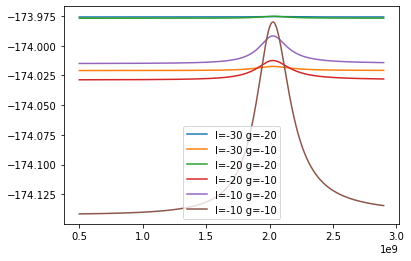

In [104]:
for leakage in range(-30,0,10):
    for reflection in range (-20,0,10):
        ntw_dict = make_circuits_variable_leakage(leakage,reflection,cav_r=100)
        blue_circuit = ntw_dict['blue']
        plt.plot(freq.f,10*np.log10(abs(blue_circuit.cs[:,0,0]/.001)),label='l='+str(leakage)+' g='+str(reflection))
        plt.legend()

#### Noise temp plots for blue circuit with and without amplifiers 
(measured leakage and reflection)

In [105]:
np.shape(blue_circuit_amps_cold_termi.s)

(1001, 1, 1)

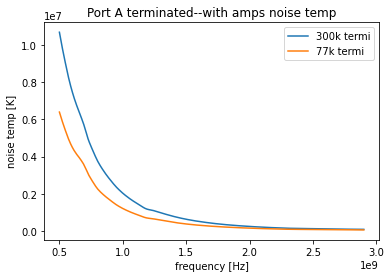

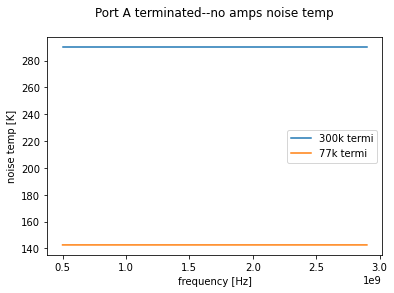

In [106]:
ntw_dict = make_circuits_variable_leakage(leakage= -30,reflection= -22,cav_r=100)
blue_circuit_amps = ntw_dict['blue_amps']
blue_circuit_amps_cold_termi = ntw_dict['blue_amps_cold_termi']
blue_circuit = ntw_dict['blue']
blue_circuit_cold_termi = ntw_dict['blue_cold_termi']

blue_circuit_temp = np.abs(blue_circuit.cs[:,0,0])/(K_BOLTZMANN * np.abs(1 - blue_circuit.s[:,0,0]**2) )
blue_circuit_amps_temp = np.abs(blue_circuit_amps.cs[:,0,0])/(K_BOLTZMANN * np.abs(1 - blue_circuit_amps.s[:,0,0]**2) )
blue_circuit_amps_cold_termi_temp = np.abs(blue_circuit_amps_cold_termi.cs[:,0,0])/(K_BOLTZMANN * np.abs(1 - blue_circuit_amps_cold_termi.s[:,0,0]**2) )
blue_circuit_cold_termi_temp = np.abs(blue_circuit_cold_termi.cs[:,0,0])/(K_BOLTZMANN * np.abs(1 - blue_circuit_cold_termi.s[:,0,0]**2) )


# Blue circuit-- with amps plot
plt.plot( freq.f, blue_circuit_amps_temp, label = '300k termi' )
plt.xlabel('frequency [Hz]'); plt.ylabel('noise temp [K]'); plt.title('Port A terminated--with amps noise temp'); 

plt.plot( freq.f, blue_circuit_amps_cold_termi_temp, label ='77k termi' );#plt.xlim(1.8e9,2.2e9);plt.ylim(0,.5e6)
plt.legend();plt.show()

# Blue circuit-- no amps plot
plt.plot( freq.f, blue_circuit_temp, label = '300k termi' );#plt.xlim(1.8e9,2.2e9)
plt.xlabel('frequency [Hz]'); plt.ylabel('noise temp [K]');plt.title('Port A terminated--no amps noise temp\n'); 

plt.plot( freq.f, blue_circuit_cold_termi_temp, label ='77k termi' )
plt.legend(); plt.show() 



#### Cavity connected directly to amplifier noise temp
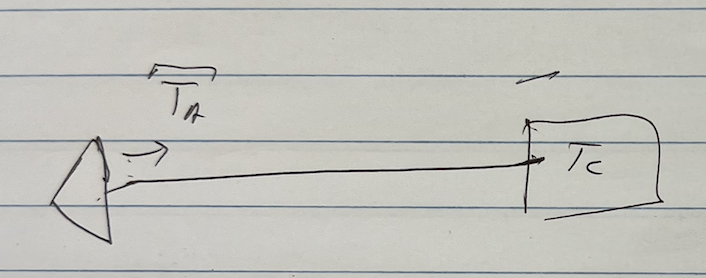

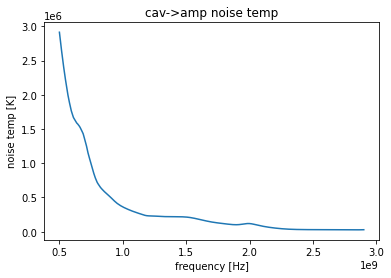

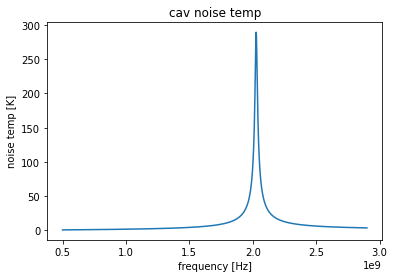

In [99]:
amp_cav_circuit = ntw_dict['amp_cav']
amp_cav_circuit_temp = np.abs(amp_cav_circuit.cs[:,0,0])/(K_BOLTZMANN * np.abs(1 - amp_cav_circuit.s[:,0,0]**2) )

cav_circuit = ntw_dict['cav']
cav_circuit_temp = np.abs(cav_circuit.cs[:,0,0])/(K_BOLTZMANN * np.abs(1 - cav_circuit.s[:,0,0]**2) )

# cav->amp noise temp plot
plt.plot( freq.f, amp_cav_circuit_temp )
plt.xlabel('frequency [Hz]'); plt.ylabel('noise temp [K]'); plt.title('cav->amp noise temp');  plt.show(); #plt.xlim(1.9e9,2.1e9);

#cav noise temp plot
plt.plot( freq.f, cav_circuit_temp )
plt.xlabel('frequency [Hz]'); plt.ylabel('noise temp [K]'); plt.title('cav noise temp'); plt.show()

#### Plotting reflection off cavity vs transmission through circulator


Expected result:

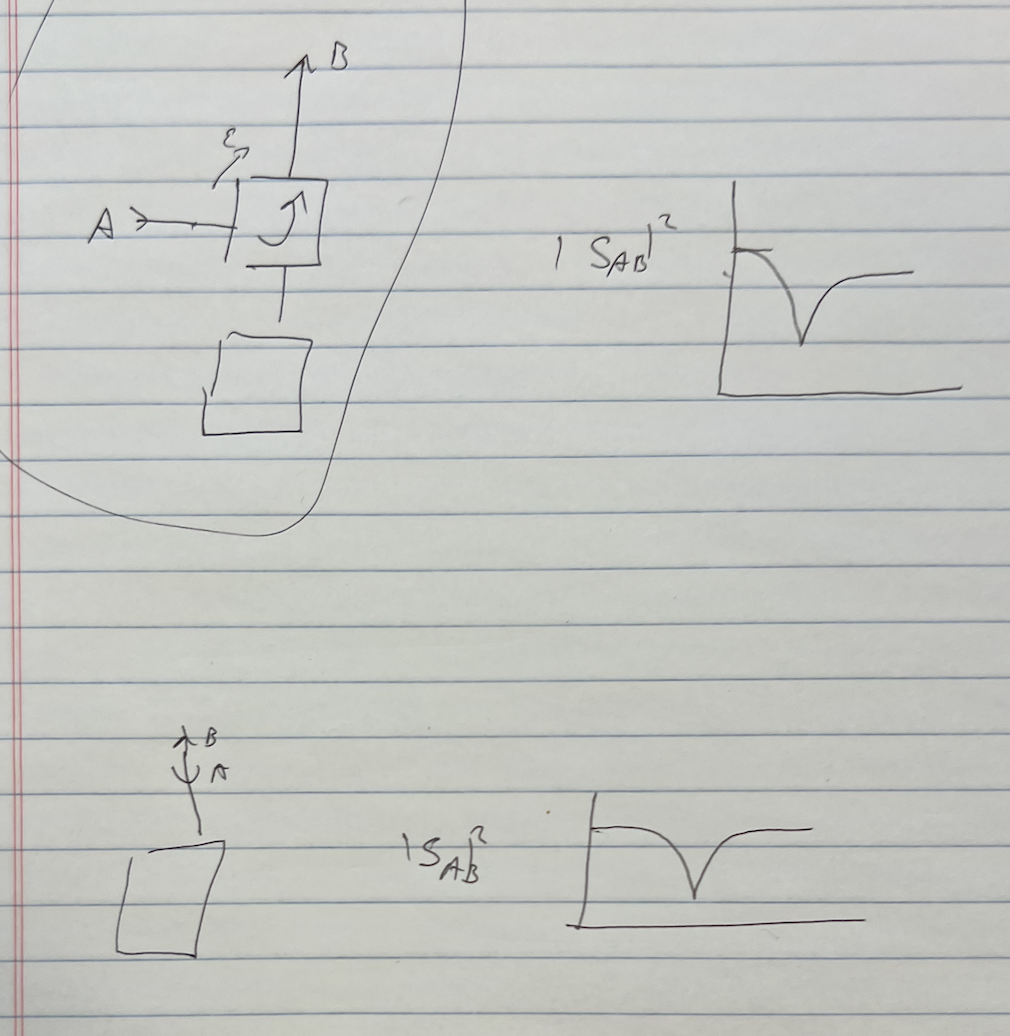

##### Case 1: reflection off cavity

Text(0, 0.5, '$|S_{11}|^2$')

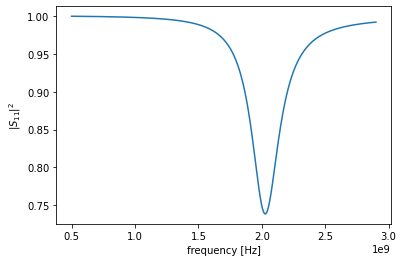

In [100]:
plt.plot( freq.f,np.abs( noisy_ntw_cav.s[:,0,0] )**2 ); plt.xlabel('frequency [Hz]'); plt.ylabel('$|S_{11}|^2$')

##### Case 2: transmission through circulator

Text(0, 0.5, '$|S_{21}|^2$')

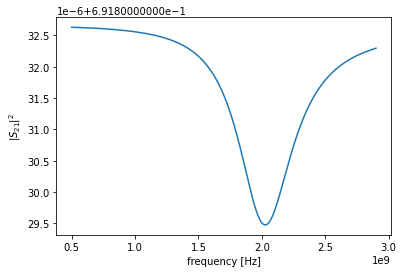

In [101]:
ntw_dict = make_circuits_variable_leakage(leakage= -30,reflection= -22,cav_r= 50)
case2_circuit = ntw_dict['case2']
plt.plot( freq.f,np.abs( case2_circuit.s[:,1,0] )**2 ); plt.xlabel('frequency [Hz]'); plt.ylabel('$|S_{21}|^2$')

##### Noise temp of circulator with two ports terminated

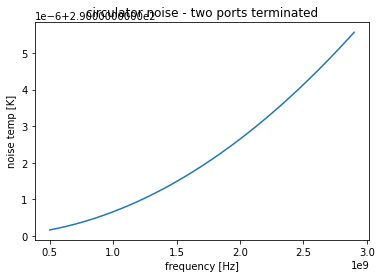

In [102]:

circ_circuit = ntw_dict['circ']

circ_circuit_temp = np.abs(circ_circuit.cs[:,0,0])/(K_BOLTZMANN * np.abs(1 - circ_circuit.s[:,0,0]**2) )

# circulator circuit
plt.plot( freq.f, circ_circuit_temp, label = '300k termi' )
plt.xlabel('frequency [Hz]'); plt.ylabel('noise temp [K]'); plt.title('circulator noise - two ports terminated');
# plt.xlim(1.8e9,2.2e9)

